# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

完成并连同作业缴交此完整的工作表(包括其输出及工作表外的任何支援程式码)。

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

这个练习类似于SVM练习。你会:

-为Softmax分类器实现一个完全向量化的**损失函数**

-实现其**解析梯度**的全向量化表达式

-**检查你的实现**用数值梯度

-使用验证集**调整学习率和正则化**强度

-用**SGD** **优化**损耗函数

-**可视化**最后学习的权重


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    从磁盘加载CIFAR-10数据集并执行预处理，为线性分类器做好准备。
    这些步骤与我们在SVM中使用的步骤相同，但是被压缩为一个函数。
    """
    # Load the raw CIFAR-10 data
#     cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = 'E:\cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# 调用上面的函数来获取数据。
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 

分类评分向量f中的第j个元素 softmax 函数：$f_j(z)=\frac{e^{z_j}}{\sum_ke^{z_k}}$

样本$i$的交叉熵损失（cross-entropy loss）：$\displaystyle L_i=-log(\frac{e^{f_{y_j}}}{\sum_je^{f_j}})=-f_{y_j}+log(\sum_je^{f_j})$

https://blog.csdn.net/zt_1995/article/details/62227603

<!-- ![image.png](attachment:image.png) -->

<img src="https://img-blog.csdn.net/20170315160017179?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvenRfMTk5NQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast" align=left width="50%">


In [3]:
# First implement the naive softmax loss function with nested loops.
# 首先用嵌套循环实现naive softmax损失函数。
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机softmax权重矩阵，用它来计算损失。
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 作为一个粗略的完整性检查，我们的损失应该接近-log(0.1)。
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.365876
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
# 完成softmax_loss_naive的实现，并实现一个梯度的(naive)版本，使用嵌套循环。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 与支持向量机一样，使用数值梯度检查作为调试工具。
# 数值梯度应接近解析梯度。
# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM的情况类似，用正则化方法再做一次梯度检查
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.094300 analytic: -1.094300, relative error: 2.248100e-08
numerical: -1.053050 analytic: -1.053050, relative error: 5.508845e-09
numerical: -0.843324 analytic: -0.843324, relative error: 3.254824e-08
numerical: -1.099520 analytic: -1.099520, relative error: 6.552973e-09
numerical: 1.421796 analytic: 1.421796, relative error: 6.204344e-10
numerical: -2.396471 analytic: -2.396471, relative error: 1.041955e-08
numerical: -0.082480 analytic: -0.082481, relative error: 2.442208e-07
numerical: 3.402114 analytic: 3.402113, relative error: 2.458817e-08
numerical: -2.605815 analytic: -2.605815, relative error: 1.714215e-08
numerical: 1.290679 analytic: 1.290679, relative error: 4.620806e-08
numerical: 2.630304 analytic: 2.630303, relative error: 1.150446e-08
numerical: 1.046108 analytic: 1.046108, relative error: 6.059228e-08
numerical: 0.443694 analytic: 0.443694, relative error: 1.133080e-07
numerical: -0.790526 analytic: -0.790526, relative error: 1.104412e-08
numerical: 1.13238

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
# 现在，我们已经有了softmax损失函数及其梯度的简单实现，
# 在softmax_loss_vectorized中实现一个向量化版本。
# 这两个版本应该计算相同的结果，但是向量化的版本应该快得多。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 与支持向量机一样，我们使用Frobenius范数来比较两个版本的梯度。
# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.365876e+00 computed in 0.229162s
vectorized loss: 2.365876e+00 computed in 0.015353s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# 使用验证集来调整超参数(正则化强度和学习率)。
# 你应该尝试不同的学习速率和正则化强度范围;
# 如果您小心的话，您应该能够在验证集上获得超过0.35的分类精度。
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 使用验证集设置学习速率和正则化强度。
# 这应该与SVM的验证相同;
# 保存最佳训练的softmax分类器在best_softmax。
pass
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters=2000)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax           
        results[(lr,rs)] = train_accuracy, val_accuracy
        


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.352143 val accuracy: 0.369000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.327653 val accuracy: 0.347000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.348204 val accuracy: 0.353000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.326653 val accuracy: 0.345000
best validation accuracy achieved during cross-validation: 0.369000


In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

假设总体训练损失被定义为所有训练示例中每个数据点损失的总和。

可以向训练集添加一个新的数据点，使SVM的损失保持不变，但Softmax分类器的损失不是这种情况。

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



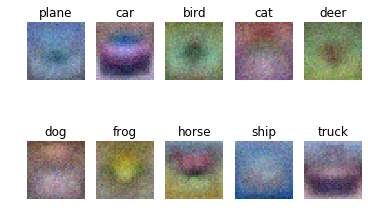

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [10]:
# # softmax函数输出 (N, C)
# num_train = 5
# softmax_output=np.random.random((num_train ,3))
# print(softmax_output)
# # softmax_output=np.array([])
# y = np.array([[1],[2],[1],[0],[2]]).reshape(1,-1)

# print(range(num_train))
# print(y)
# print(list(y))
# print(softmax_output[range(num_train), y])
# print(softmax_output[range(num_train), list(y)])
# print(softmax_output[range(num_train), list(y)].shape)
# print(np.sum(softmax_output[range(num_train), list(y)]))


[[0.78979955 0.04887747 0.22957192]
 [0.82150647 0.12743317 0.49687003]
 [0.35451674 0.44862581 0.073524  ]
 [0.0344621  0.97465547 0.19927504]
 [0.59111263 0.23095339 0.91562976]]
range(0, 5)
[[1 2 1 0 2]]
[array([1, 2, 1, 0, 2])]
[[0.04887747 0.49687003 0.44862581 0.0344621  0.91562976]]
[[0.04887747 0.49687003 0.44862581 0.0344621  0.91562976]]
(1, 5)
1.9444651599009182
